# Выбор локации для скважины. Анализ прибыли и рисков

Исследование содержит данные добывающей компании: данные геологоразведки трёх различных регионов. Основная задача — выбрать регион, в котором бурение новых скважин принесёт максимальную прибыль. Исследование включает анализ данных, обучение модели, оценку потенциальной прибыли и рисков с помощью метода Bootstrap.

**Цель исследования**:
1) Построить модель линейной регрессии для предсказания объема сырья на основе данных геологоразведки региона.
2) Определить регион, в котором добыча сырья обеспечит наибольшую прибыль с учётом возможных рисков. 

Таким образом, исследование пройдёт в **шесть этапов**:
1) Обзор данных
2) Предобработка данных
3) Исследовательский анализ данных
4) Корреляционный анализ данных
5) Обучение модели
6) Расчет прибыли и рисков

**Описание данных:**
- `id` — уникальный идентификатор скважины;
- `f0`, `f1`, `f2` — три признака точек;
- `product` — объём запасов в скважине (тыс. баррелей).

**Условия проекта**:

- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- Один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей.
- Не рассматривать регионы, в которых вероятность убытков более 2.5%. 

## Загрузка и импорт библиотек

In [1]:
# Импорт необходимых библиотек
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style='whitegrid', palette='muted')

In [2]:
def data_info (df):
    '''
    Отображает первые 5 строк, общую информацию и описательную статистику DataFrame.

    '''
    display(df.head())
    df.info()
    display(df.describe().round(3))

In [3]:
def remove_outliers(df, column):
    '''
    Удаляет выбросы (значения за пределами 1,5 межквартильного размаха) 
    из указанного столбца DataFrame.

    Parameters:
        df (pandas.DataFrame): DataFrame.
        column (str): столбец, из которого необходимо удалить выбросы.
    Returns:
        df_without_outliers (pandas.DataFrame): DataFrame без выбросов.
    '''

    # Определение 1 и 3 квантиля, межквартильного размаха
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Границы для выбросов
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Удаление выбросов
    df_without_outliers = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    return df_without_outliers

In [4]:
def plt_hist_box(df, bins=10, pallete='crest'):
    '''
    Строит гистограмму и диаграмму размаха для всех столбцов указанного DataFrame.
    
    Parameters:
        df (pandas.DataFrame): DataFrame.
        bins (int, optional): Количество бинов для гистограммы. По умолчанию 10.
    '''
    # Сохранение названий столбцов в список
    columns = df.columns.to_list()

    # Цветовое оформление графиков
    colors = sns.color_palette(pallete, len(columns))

    for i, col in enumerate(columns):
        
        # Описательные статистики
        print(f'Описательные статистики параметра {col}')
        display(pd.DataFrame(df[col].describe()).T.style.format(precision=3))
        
        # Построение графиков
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
    
        # Гистограмма
        sns.histplot(data=df, x=col, bins=bins, ax=ax1, color=colors[i])
        ax1.set_title(f'Гистограмма - {col}', fontsize=14)
        ax1.set_xlabel('тыс.баррелей' if col == 'product' else col)
        ax1.set_ylabel('Частота')

        # Диаграмма размаха
        sns.boxplot(data=df, y=col, ax=ax2, color=colors[i], width=.5)
        ax2.set_title(f'Диаграмма размаха - {col}', fontsize=14)
        ax2.set_ylabel('тыс.баррелей' if col == 'product' else col)

        plt.tight_layout()
        plt.show()

In [5]:
def scatterplt_for_target(df, alpha=0.5):
    '''
    Строит диаграммы рассения для указанного DataFrame c целевой
    переменной 'product' и списком входных переменных.
    
    Parameters:
        df (pandas.DataFrame): DataFrame.
        alpha (float): параметр для установки прозрачности точек графика. По умолчанию 0.5.
    '''
    # Размер графика
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes = axes.flatten()

    # Столбцы для графиков
    columns = ['f0', 'f1', 'f2']

    # Построение графиков
    for i, col in enumerate(columns):
        sns.scatterplot(data=df, x='product', y=col, ax=axes[i], alpha=alpha)
        axes[i].set_title(f'Диаграмма рассеяния: product - {col}', fontsize=14)
        axes[i].set_ylabel(col)
        axes[i].set_xlabel('product, тыс.баррелей')

In [6]:
def corr_heatmap(df, title, method='spearman', figsize=(6, 5)):
    '''
    Создает тепловую карту корреляции для числовых столбцов в указанном DataFrame.
    
    Parameters:
        df (pandas.DataFrame): DataFrame.
        title (str): Заголовок графика.
        method (str): Метод для расчета корреляции. По умолчанию 'spearman'
    '''
    # Расчет корреляции
    df_corr = df.corr(method=method).round(3)

    # Тепловая карта
    plt.figure(figsize=figsize)
    sns.heatmap(df_corr, annot=True, fmt='.3f', annot_kws={"size": 10})
    plt.title(title)
    plt.show()

## Загрузка и обзор данных

In [7]:
# Загрузка данных
try:
    geo_data_0 = pd.read_csv('geo_data_0.csv')
    geo_data_1 = pd.read_csv('geo_data_1.csv')
    geo_data_2 = pd.read_csv('geo_data_2.csv')
    print('Данные успешно загружены')
except:
    print('Ошибка при загрузке')

Данные успешно загружены


In [8]:
# Вывод общей информации о датафрейме `geo_data_0`
data_info(geo_data_0)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,f0,f1,f2,product
count,100000.000,100000.000,100000.000,100000.000
mean,0.500,0.250,2.503,92.500
std,0.872,0.504,3.248,44.289
min,-1.409,-0.848,-12.088,0.000
25%,-0.073,-0.201,0.288,56.498
50%,0.502,0.250,2.516,91.850
75%,1.074,0.701,4.715,128.564
max,2.362,1.344,16.004,185.364


In [9]:
# Вывод общей информации о датафрейме `geo_data_1`
data_info(geo_data_1)

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,f0,f1,f2,product
count,100000.000,100000.000,100000.000,100000.000
mean,1.141,-4.797,2.495,68.825
std,8.966,5.120,1.704,45.944
min,-31.610,-26.359,-0.018,0.000
25%,-6.299,-8.268,1.000,26.953
50%,1.153,-4.813,2.011,57.086
75%,8.621,-1.333,4.000,107.813
max,29.422,18.734,5.020,137.945


In [10]:
# Вывод общей информации о датафрейме `geo_data_2`
data_info(geo_data_2)

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,f0,f1,f2,product
count,100000.000,100000.000,100000.000,100000.000
mean,0.002,-0.002,2.495,95.000
std,1.732,1.730,3.473,44.750
min,-8.760,-7.084,-11.970,0.000
25%,-1.162,-1.175,0.130,59.450
50%,0.009,-0.009,2.484,94.926
75%,1.159,1.164,4.859,130.595
max,7.238,7.845,16.739,190.030


**Общая предварительная оценка данных:**
- Набор данных достаточен для исследовательского анализа.
- Данные разделены на 3 датафрейма (**geo_data_0**, **geo_data_1**, **geo_data_2**), каждый из которых содержит 100 000 строк с информацией геологоразведки региона.
- В данных могут содержатся дубликаты.

Для дальнейшей работы с данными выполним их предобработку.

## Предобработка данных

### Исследование пропусков

In [11]:
# Словарь со всеми датафреймами
all_df = {
    'geo_data_0': geo_data_0,
    'geo_data_1': geo_data_1,
    'geo_data_2': geo_data_2
}

In [12]:
# Подсчет количества пропусков
for name, df in all_df.items():
    print(f'Количество пропущенных значений в {name}:\n', df.isna().sum(), '\n')

Количество пропущенных значений в geo_data_0:
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64 

Количество пропущенных значений в geo_data_1:
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64 

Количество пропущенных значений в geo_data_2:
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64 



Пропусков ни в одном из датафреймов не обнаружили.

### Исследование дубликатов

#### Явные дубликаты

In [13]:
# Подсчет количества явных дубликатов
for name, df in all_df.items():
    print(f'Количество явных дубликатов в {name}:', df.duplicated().sum())

Количество явных дубликатов в geo_data_0: 0
Количество явных дубликатов в geo_data_1: 0
Количество явных дубликатов в geo_data_2: 0


Явных дубликатов ни в одном из датафреймов не обнаружили.

#### Неявные дубликаты

Также проверим наличие неявных дубликатов в столбце с уникальными идентификаторами скважин - `id`.

In [14]:
# Подсчет количества дубликатов в столбце 'id'
for name, df in all_df.items():
    print(f'Количество дубликатов в столбце `id` в {name}:', df['id'].duplicated().sum(), 
          'или', df['id'].duplicated().sum()/len(df)*100, '% от всего датафрейма')

Количество дубликатов в столбце `id` в geo_data_0: 10 или 0.01 % от всего датафрейма
Количество дубликатов в столбце `id` в geo_data_1: 4 или 0.004 % от всего датафрейма
Количество дубликатов в столбце `id` в geo_data_2: 4 или 0.004 % от всего датафрейма


Данные в предоставленных датасетах синтетические и у нас нет возможности выяснить природу появления данных дубликатов. Т.к. столбец `id` не будет участвовать в обучении модели и количество дубликатов малозначительное, оставим строки с дублирующимися id **без изменений**.

Для упрощения дальнейшей работы с признаками определим столбцы `id` в качестве индексов:

In [15]:
# Установка столбца `id` в качестве индекса
for name, df in all_df.items():
    df.set_index('id', inplace=True)
    display(df.head(2))

,f0,f1,f2,product
id,,,,
txEyH,0.705745,-0.497823,1.22117,105.280062
2acmU,1.334711,-0.340164,4.36508,73.037750


,f0,f1,f2,product
id,,,,
kBEdx,-15.001348,-8.276000,-0.005876,3.179103
62mP7,14.272088,-3.475083,0.999183,26.953261


,f0,f1,f2,product
id,,,,
fwXo0,-1.146987,0.963328,-0.828965,27.758673
WJtFt,0.262778,0.269839,-2.530187,56.069697


**В результате предобработки данных**:

* Были обнаружены неявные дубликаты в 3-ёх датафреймах в столбце `id`. Они составили 0,006% от всего объема данных. Т.к. этот столбец не будет использоваться при обучении модели и количество дубликатов малозначительное, оставили их без изменений.
* Столбец `id` был установлен в качестве индекса.
* Были проверены пропущенные значения, их не обнаружили.

## Исследовательский анализ данных

Проанализируем более подробно все параметры по каждому датафрейму:

### Анализ датафрейма 'geo_data_0'

Описательные статистики параметра f0


,count,mean,std,min,25%,50%,75%,max
f0,100000.000,0.500,0.872,-1.409,-0.073,0.502,1.074,2.362


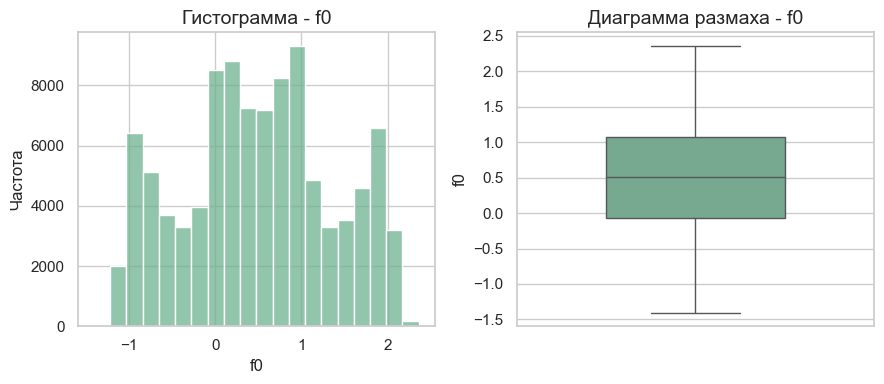

Описательные статистики параметра f1


,count,mean,std,min,25%,50%,75%,max
f1,100000.000,0.250,0.504,-0.848,-0.201,0.250,0.701,1.344


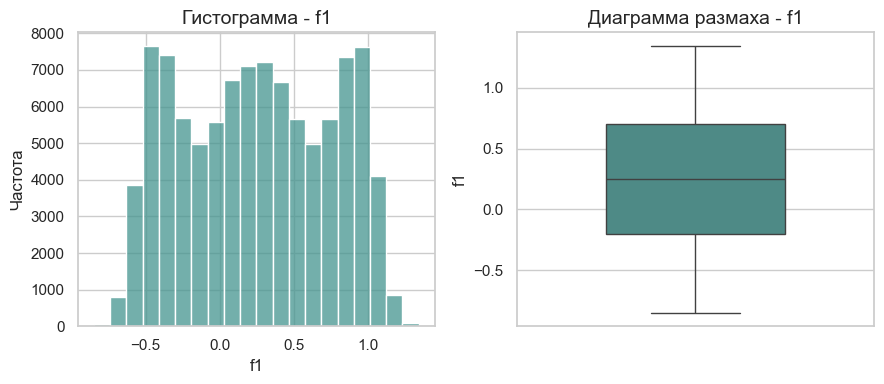

Описательные статистики параметра f2


,count,mean,std,min,25%,50%,75%,max
f2,100000.000,2.503,3.248,-12.088,0.288,2.516,4.715,16.004


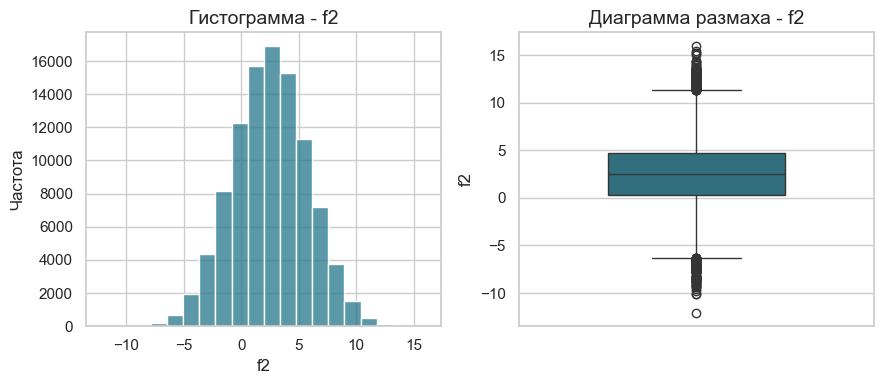

Описательные статистики параметра product


,count,mean,std,min,25%,50%,75%,max
product,100000.000,92.500,44.289,0.000,56.498,91.850,128.564,185.364


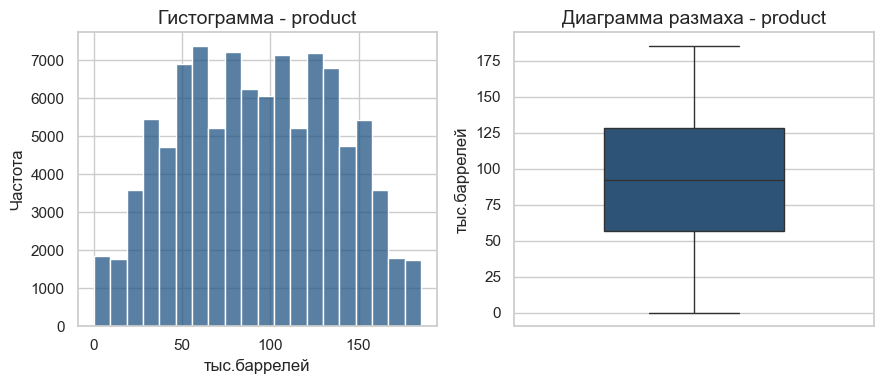

In [16]:
# Графики по датафрейму 'geo_data_0'
plt_hist_box(geo_data_0, bins=20)

* `f0`- Среднее значение составляет **0.5**. Распределение имеет несколько пиков, что указывает на **мультимодальность**. Наибольшее количество наблюдений сосредоточено в диапазоне от 0 до 1.5. На диаграмме размаха не наблюдается выбросов и аномалий.
* `f1` - Среднее значение - **0.25**. На гистограмме наблюдаем несколько пиков, но они расположены близко друг другу, поэтому данные распределены относительно равномерно. Распределение симметрично, без выбросов.
* `f2` - Признак имеет нормальное распределение со средним значением **2.5**. На диаграмме размаха наблюдаем выбросы (значения свыше 11 и менеее -6). Т.к. мы не располагаем информацией о самом признаке (что он представляет; какие значения для него могут быть ошибочными и аномальными), природу обнаруженных выбросов невозможно определить. Но исходя из того, что в качестве модели будет использоваться линейная регрессия, а на ее результаты выбросы влияют негативно, избавимся от них. А именно удалим значения, выходящие за пределы 1.5 * IQR от первого квартиля (Q1) и третьего квартиля (Q3).
* `product` (целевой признак) - Среднее значение составляет **92.5** тыс.баррелей. Наибольшее количество наблюдений находится в диапазоне от 55 до 130 тыс.баррелей. Распределение симметрично, без выбросов.

In [17]:
# Удаление выбросов из столбца `f2` датафрейма `geo_data_0`
geo_data_0_clean = remove_outliers(geo_data_0, 'f2')

# Проверка результатов
print(
    f'Количество удаленных выбросов - {geo_data_0.shape[0] - geo_data_0_clean.shape[0]} строк '
    f'или {(geo_data_0.shape[0] - geo_data_0_clean.shape[0]) / len(geo_data_0) * 100:.3f} % от исходного датафрейма'
)

Количество удаленных выбросов - 506 строк или 0.506 % от исходного датафрейма


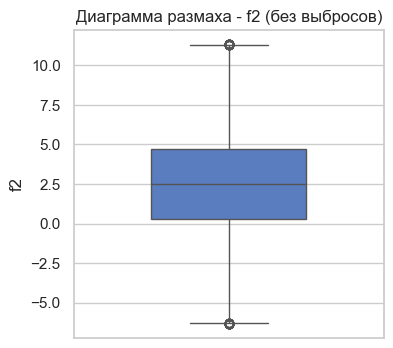

In [18]:
# Диаграмма размаха по столбцу `f2` без выбросов
plt.figure(figsize=(4, 4))
(
    sns
    .boxplot(geo_data_0_clean, y='f2', width=.5)
    .set(title='Диаграмма размаха - f2 (без выбросов)', ylabel='f2')
);

Далее построим диаграммы рассения для целевого признака `product` и количественных входных признаков `f0`, `f1`, `f2`:

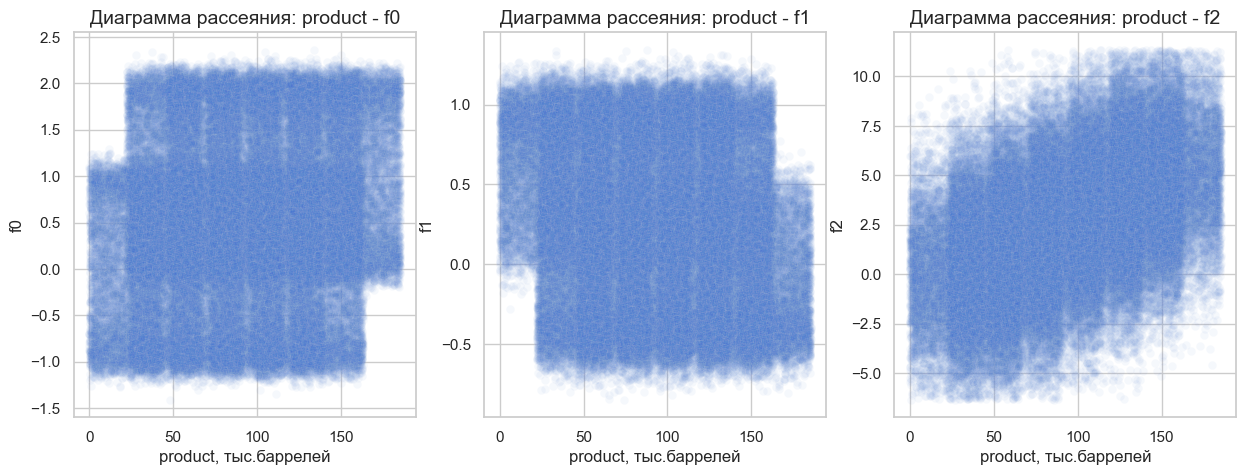

In [19]:
# Диаграммы рассеяния для 'product' и входных признаков
scatterplt_for_target(geo_data_0_clean, alpha=0.05)

* `product-f0` - На диаграмме **нет линейной зависимости**, точки рассеяны по области графика довольно равномерно. Однако наблюдается некоторое разделение данных на две области по оси f0: одна группа в интервале  от -1.2 до 1, а другая – от 0 до 2.2. Это может указывать на наличие двух кластеров.
* `product-f1` - Ситуация аналогична product-f0: **линейной зависимости нет**, но присутствует некоторое разделение на 2 кластера по оси f1 (одна группа в диапазое от -0.7 до 0.5, вторая группа -от 0 до 1.5.
* `product-f2` - Точки на графике распределены достаточно равноверно, однако наблюдается слабая линейная зависимость: с увеличением f2 возрастает показатель product. Более детально зависимость между параметрами рассмотрим при корреляционном анализе.

### Анализ датафрейма 'geo_data_1'

Описательные статистики параметра f0


,count,mean,std,min,25%,50%,75%,max
f0,100000.000,1.141,8.966,-31.610,-6.299,1.153,8.621,29.422


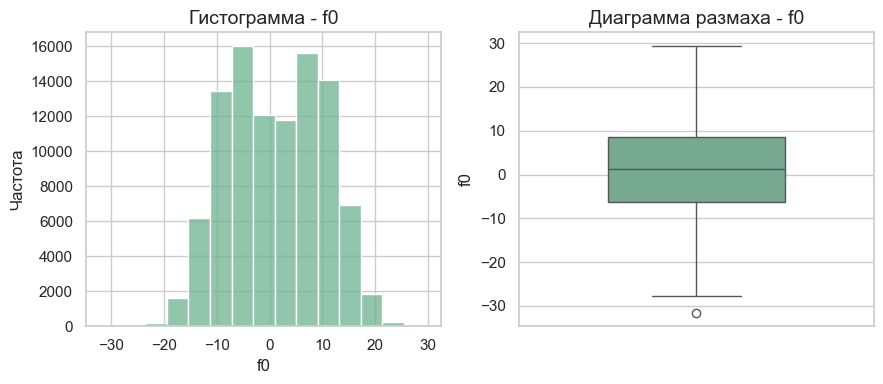

Описательные статистики параметра f1


,count,mean,std,min,25%,50%,75%,max
f1,100000.000,-4.797,5.120,-26.359,-8.268,-4.813,-1.333,18.734


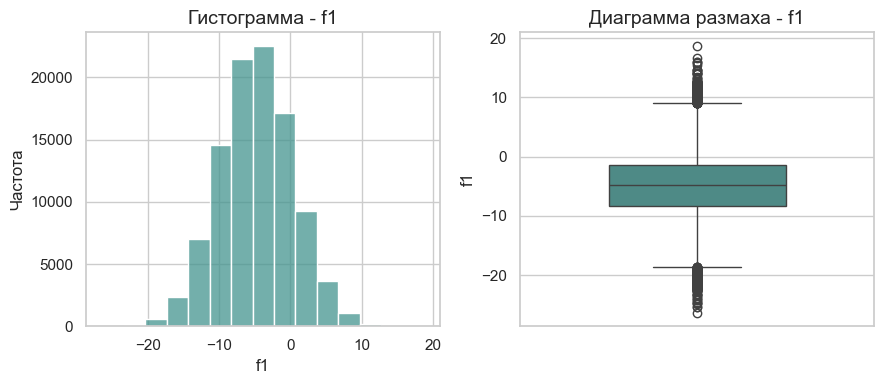

Описательные статистики параметра f2


,count,mean,std,min,25%,50%,75%,max
f2,100000.000,2.495,1.704,-0.018,1.000,2.011,4.000,5.020


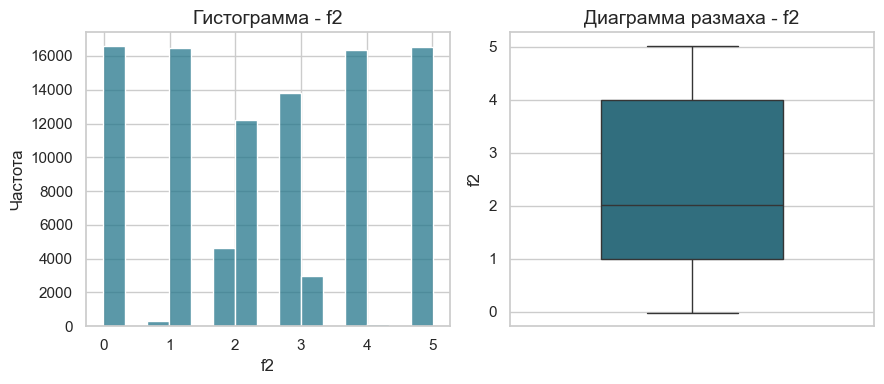

Описательные статистики параметра product


,count,mean,std,min,25%,50%,75%,max
product,100000.000,68.825,45.944,0.000,26.953,57.086,107.813,137.945


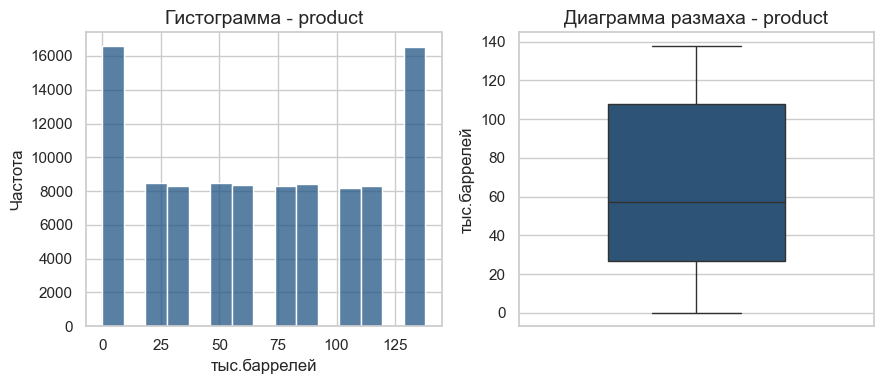

In [20]:
# Графики по датафрейму 'geo_data_1'
plt_hist_box(geo_data_1, bins=15)

* `f0`- Среднее значение составляет **1.1**. Распределение имеет два пика, что указывает на **мультимодальность**. Наибольшее количество наблюдений сосредоточено в диапазоне от -10 до 10. На диаграмме размаха наблюдаем единичный выброс со значением менее -30, удалим его.
* `f1` - Признак распределен нормально со средним значением **-4.8**. На диаграмме размаха наблюдаем выбросы со значениями свыше 10 и менее -20, также избавимся от них.
* `f2` - Распределение координально отличается от датафрейма geo_data_0. Признак имеет многомодальное распределение с несколькими пиками. Среднее значение составляет **2.5**. Данные не содержат выбросов.
* `product` - На гистограмме наблюдаем 2 пика около значений 0 и 125 тыс.баррелей. Между ними равномерное распределение. Среднее значение составляет **68.8** тыс.баррелей. Выбросов не обнаружено.

In [21]:
# Удаление выбросов из столбцов `f0`, `f1` датафрейма `geo_data_1`
geo_data_1_clean = remove_outliers(geo_data_1, 'f0')
geo_data_1_clean = remove_outliers(geo_data_1_clean, 'f1')


# Проверка результатов
print(
    f'Количество удаленных выбросов - {geo_data_1.shape[0] - geo_data_1_clean.shape[0]} строк '
    f'или {(geo_data_1.shape[0] - geo_data_1_clean.shape[0]) / len(geo_data_1) * 100:.3f} % от исходного датафрейма'
)

Количество удаленных выбросов - 637 строк или 0.637 % от исходного датафрейма


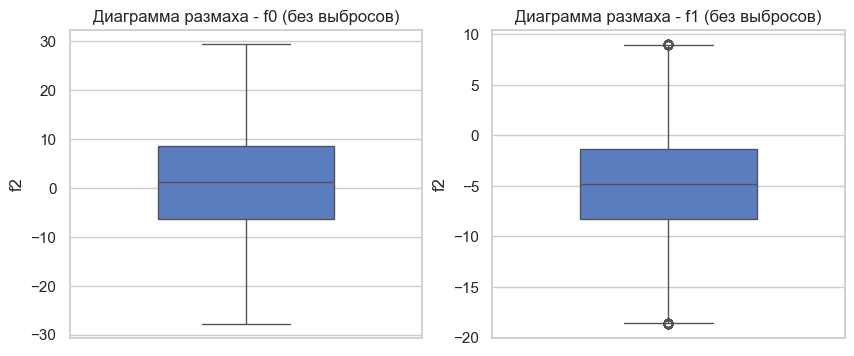

In [22]:
# Диаграмма размаха по столбцам `f0`, `f1` без выбросов
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
geo_data_1_outliers_columns = ['f0', 'f1']
for i, col in enumerate(geo_data_1_outliers_columns):
    (
        sns
        .boxplot(geo_data_1_clean, y=col, width=.5, ax=axes[i])
        .set(title=f'Диаграмма размаха - {col} (без выбросов)', ylabel='f2')
    )

Далее построим диаграммы рассения для целевого признака `product` и количественных входных признаков `f0`, `f1`, `f2`:

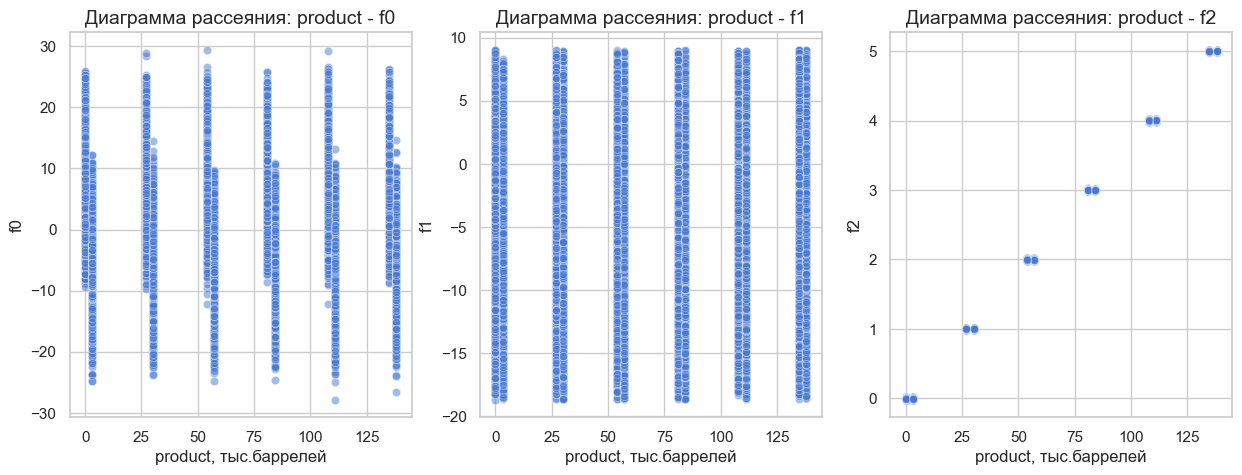

In [23]:
# Диаграммы рассеяния для 'product' и входных признаков
scatterplt_for_target(geo_data_1_clean)

* `product-f0` - **Линейной взаимосвязи нет**, точки распределены по области графика равномерно.
* `product-f1` - Также **не наблюдаем линейной зависимости**, значения распределены равномерно.
* `product-f2` - Между параметрами **прослеживается явная линейная зависимость**: с увеличением показателя `f2`, возрастает и показатель `product`. Взаимосвзяь параметров детальней рассмотрим при корреляционном анализе.

### Анализ датафрейма 'geo_data_2'

Описательные статистики параметра f0


,count,mean,std,min,25%,50%,75%,max
f0,100000.000,0.002,1.732,-8.760,-1.162,0.009,1.159,7.238


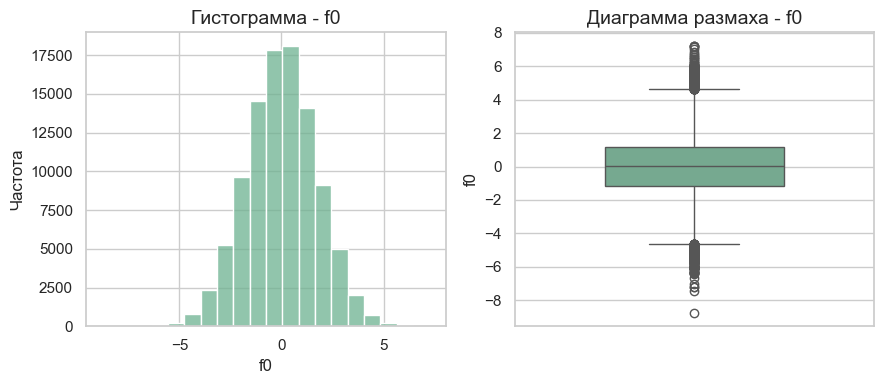

Описательные статистики параметра f1


,count,mean,std,min,25%,50%,75%,max
f1,100000.000,-0.002,1.730,-7.084,-1.175,-0.009,1.164,7.845


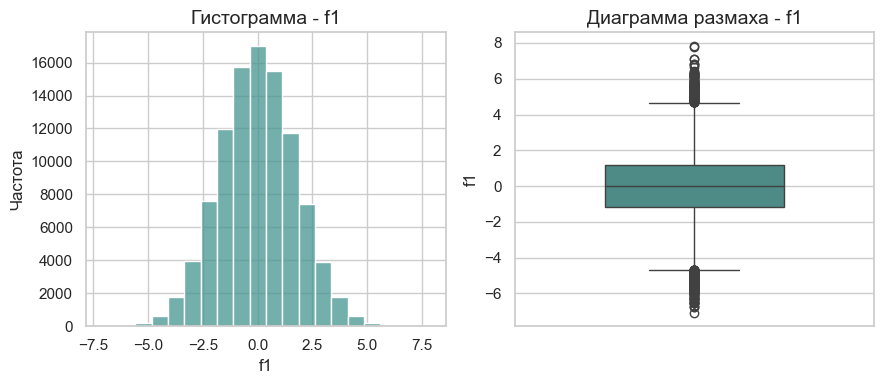

Описательные статистики параметра f2


,count,mean,std,min,25%,50%,75%,max
f2,100000.000,2.495,3.473,-11.970,0.130,2.484,4.859,16.739


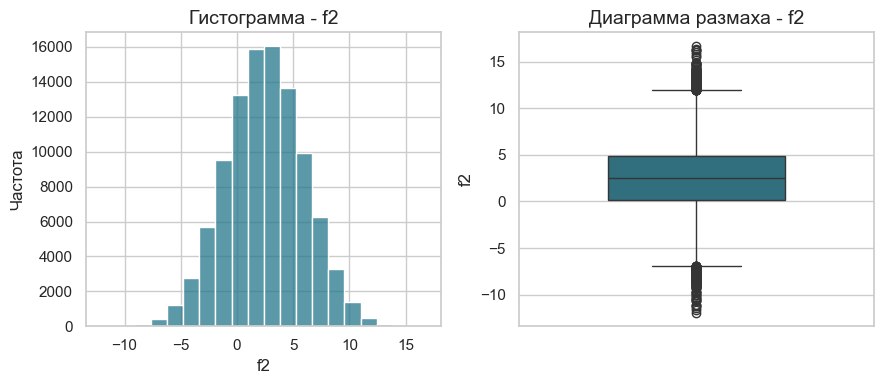

Описательные статистики параметра product


,count,mean,std,min,25%,50%,75%,max
product,100000.000,95.000,44.750,0.000,59.450,94.926,130.595,190.030


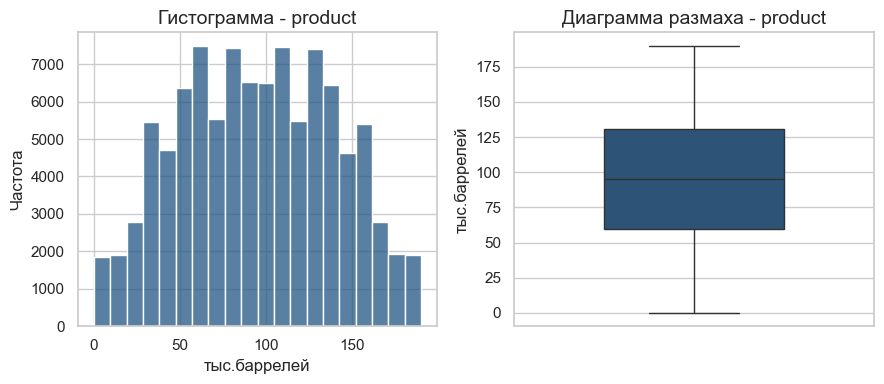

In [24]:
# Графики по датафрейму 'geo_data_2'
plt_hist_box(geo_data_2, bins=20)

* `f0`- Параметр имеет нормальное распределение со средним значением **0.002**. На диаграмме размаха наблюдаем выбросы (значения более 5 и менее -5), удалим их.
* `f1` - Данный признак также нормально распределен. Среднее значение составляет **-0.002**. Обнаруженные выбросы со значениями более 5 и менее -5 удалим.
* `f2` - Данные распределены нормально со средним значением **2.5**. На диаграмме размаха наблюдаем выбросы, также избавимся от них.
* `product` - Среднее значение составляет **95** тыс.баррелей. Наибольшее количество наблюдений находится в диапазоне от 50 до 140 тыс.баррелей. Распределение симметрично, без выбросов.

In [25]:
# Удаление выбросов из столбцов `f0`, `f1`, 'f2' датафрейма `geo_data_2`
geo_data_2_clean = remove_outliers(geo_data_2, 'f0')
geo_data_2_clean = remove_outliers(geo_data_2_clean, 'f1')
geo_data_2_clean = remove_outliers(geo_data_2_clean, 'f2')


# Проверка результатов
print(
    f'Количество удаленных выбросов - {geo_data_2.shape[0] - geo_data_2_clean.shape[0]} строк '
    f'или {(geo_data_2.shape[0] - geo_data_2_clean.shape[0]) / len(geo_data_2) * 100:.3f} % от исходного датафрейма'
)

Количество удаленных выбросов - 1997 строк или 1.997 % от исходного датафрейма


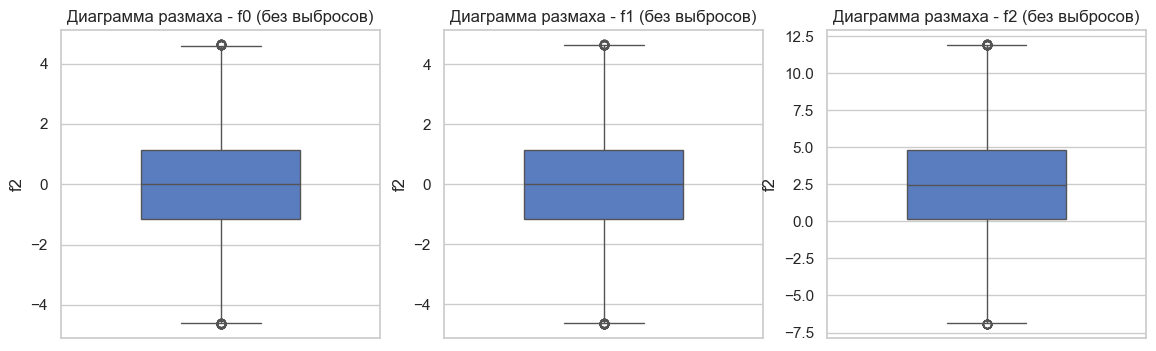

In [26]:
# Диаграмма размаха по столбцам `f0`, `f1`, 'f2' без выбросов
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
geo_data_2_outliers_columns = ['f0', 'f1', 'f2']
for i, col in enumerate(geo_data_2_outliers_columns):
    (
        sns
        .boxplot(geo_data_2_clean, y=col, width=.5, ax=axes[i])
        .set(title=f'Диаграмма размаха - {col} (без выбросов)', ylabel='f2')       
    )

Далее построим диаграммы рассения для целевого признака `product` и количественных входных признаков `f0`, `f1`, `f2`:

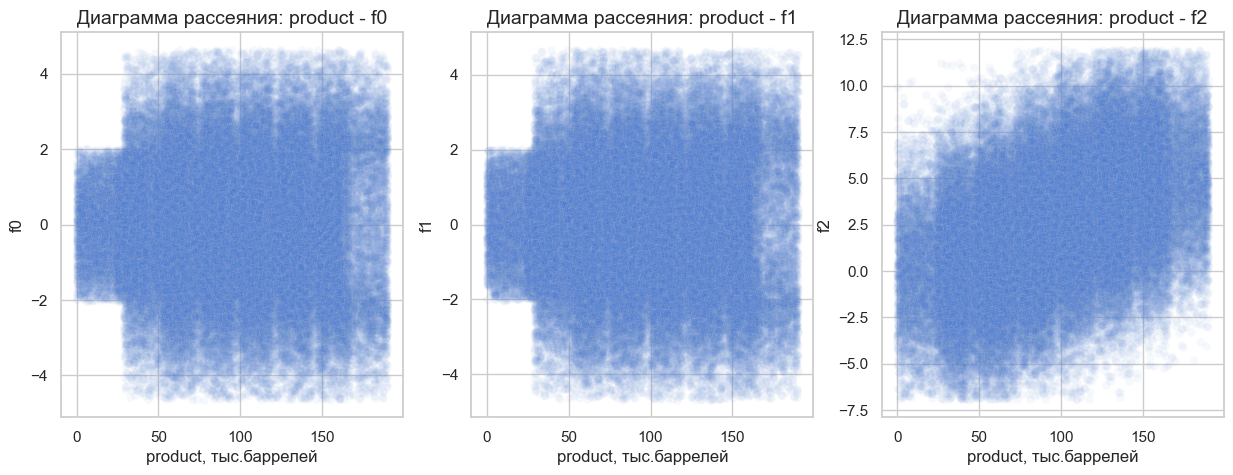

In [27]:
# Диаграммы рассеяния для 'product' и входных признаков
scatterplt_for_target(geo_data_2_clean, alpha=0.05)

* `product-f0` - На диаграмме **нет линейной зависимости**, точки рассеяны равномерно. Однако на графике выделяется группа значений `product` до 30 тыс.баррелей - показатель `f0` в ней принимает только значения в диапазоне от -2 до 2.
* `product-f1` - Ситуация аналогична product-f0: **линейной зависимости нет**, выделяется группа значений `product` до 30 тыс.баррелей - показатель `f0` в ней находится в диапазоне от -2 до 2.
* `product-f2` - Точки на графике распределены достаточно равноверно, однако наблюдается слабая линейная зависимость: с увеличением f2 возрастает показатель product. Более детально зависимость между параметрами рассмотрим при корреляционном анализе.

**Выводы**:

Рассмотрев основные данные геологоразведки трёх регионов, мы проанализировали распределение значений по каждому параметру, выявили средние значения, а также аномальные. В результате:

- Во всех трёх датафреймах наблюдаются признаки мультимодальности (особенно по признаку `f0`), что может указывать на наличие нескольких кластеров данных.
- Признаки `f0`, `f1`, и `f2` в целом имеют различные распределения: от мультимодальных до нормальных.
- Целевой признак `product` везде имеет симметричное распределение и не содержит выбросов.
- Были обнаружены и удалены выбросы во входных признаках (`f0`, `f1`, и `f2`) в каждом из датафреймов, что улучшит качество данных для последующего моделирования.
- Линейной зависимости между признаками `f0`, `f1` и целевым признаком `product` не выявлено, однако есть указания на возможное разделение данных на кластеры.
- Признак `f2` во втором датафрейме имеет ярко выраженную линейную взаимосвязь с целевым показателем `product`. В первом и третьем же датафреймах демонстрирует слабую линейную зависимость.

## Корреляционный анализ

Изучим взаимосвязь между признаками по каждому датафрейму. Для этого рассчитаем коэффициенты корреляции и построим тепловую карту. При рассчете корреляции будем использовать **коэффициент корреляции Спирмена**, т.к. большинство параметров не имеет нормального распределения и линейной взаимосвязи между собой.

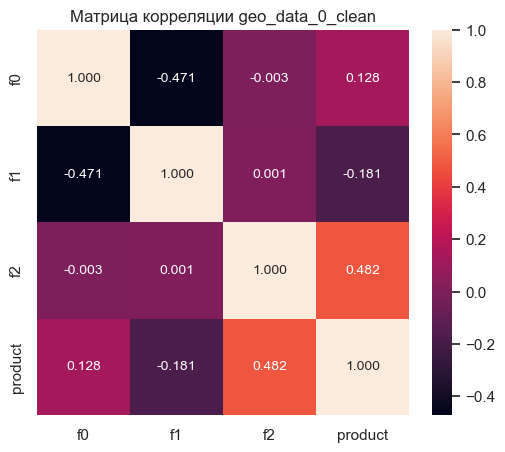

In [28]:
# Матрица корреляции для `geo_data_0`
corr_heatmap(geo_data_0_clean, 'Матрица корреляции geo_data_0_clean')

Датафрейм **geo_data_0_clean**:
- Целевой параметр `product` имеет умеренный уровень корреляции с признаком `f2` - коэффициент **0.482**. С остальными параметрами наблюдается слабая корреляция (коэффициенты 0.128 и -0.181).
- Мультиколлениарности среди входных признаков не наблюдаем (коэффициенты ниже 0.5).

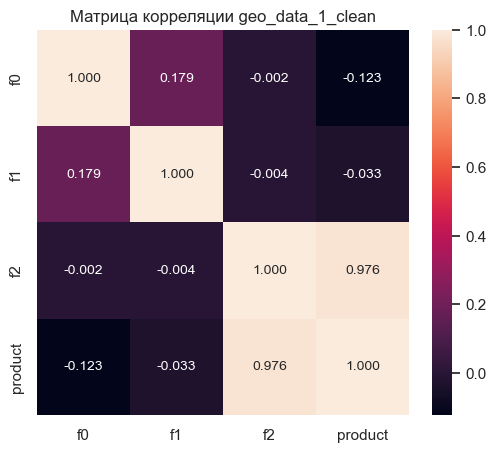

In [29]:
# Матрица корреляции для `geo_data_1`
corr_heatmap(geo_data_1_clean, 'Матрица корреляции geo_data_1_clean')

Датафрейм **geo_data_1_clean**:
- Целевой параметр `product` имеет весьма высокую корреляцию с признаком `f2` - коэффициент **0.976**, что свидетельствует о сильной взаимосвязи между признаками. С остальными параметрами наблюдается слабая корреляция (коэффициенты -0.123 и -0.033).
- Мультиколлениарности среди входных признаков не наблюдаем (коэффициенты ниже 0.2).

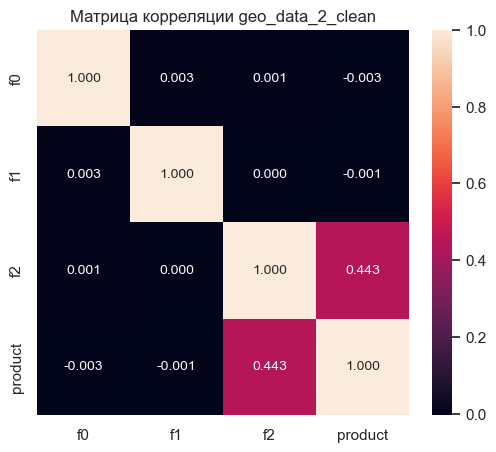

In [30]:
# Матрица корреляции для `geo_data_2`
corr_heatmap(geo_data_2_clean, 'Матрица корреляции geo_data_2_clean')

Датафрейм **geo_data_2_clean**:
- Целевой параметр `product` имеет умеренный уровень корреляции с признаком `f2` - коэффициент **0.443**. С остальными параметрами наблюдается весьма слабая корреляция, близкая к 0 (коэффициенты -0.003 и -0.001).
- Мультиколлениарности среди входных признаков не наблюдаем (коэффициенты ниже 0.1).

**Выводы**:

Проанализировав матрицы корреляции по каждому региону, выявили следующие взаимосвязи:

* Наиболее **высокий уровень корреляции** целевой признак `product` имеет **с признаком `f2`**: коэффициент 0.976 в 'geo_data_1_clean', 0.482 в 'geo_data_0_clean' и 0.443 в 'geo_data_2_clean'.
* С остальными признаками (`f0`, `f2`) целевой признак имеет слабую корреляцию: коэффициет не превышает 0.2.
* **Отсутствие мультиколлинеарности** среди входных признаков (все коэффициенты корреляции ниже 0.5).

## Обучение модели

Для предсказания объёма запасов будем использовать **модель линейной регрессии**. Для масштабирования количественных признаков будет использован **StandardScaler()**. Создадим функцию для подготовки данных, обучения модели и получения предсказаний:

In [31]:
def linear_reg_predict (df, region_name, target='product', 
                        random_state=42, valid_size=0.25):
    '''
    Обучает модель LinearRegression и получает предсказание целевого признака.
    Подготавливает данные к обучению.
    
    Parameters:
        df (pandas.DataFrame): DataFrame
        region_name (str): название  региона.
        target (srt): столбец с целевым признаком. По умолчанию 'product'.
        random_state (int): параметр для генерации псевдослучайных величин. По умолчанию 42.
        valid_size (float): размер валидационной выборки. По умолчанию 0.25.
   
    Returns:
        y_df (pandas.DataFrame): DataFrame с с предсказанными и реальными значениями y.
        rmse (float): Рассчитанная метрика RMSE.
        y_predict_mean (float): Среднее значение y_predict

    '''

    # Объявление констант
    RANDOM_STATE = random_state
    VALID_SIZE = valid_size

    # Разделение на целевой и входные признаки
    X = df.drop([target], axis=1)
    y = df[target]
 
    # Разделение данных на выборки
    X_train, X_valid, y_train, y_valid = train_test_split(
        X,
        y,
        test_size = VALID_SIZE, 
        random_state = RANDOM_STATE
    )

    # Создание пайплайна
    pipe = Pipeline([
        ('scaler', StandardScaler()), 
        ('model', LinearRegression())
    ])

    # Обучение пайплайна
    pipe.fit(X_train, y_train)

    # Предсказание на валидационной выборке
    y_predict = pipe.predict(X_valid)

    # Создание датафрейма с предсказанными и реальными значения y
    y_df = pd.DataFrame({
        'y_valid': y_valid,
        'y_predict': y_predict
    })

    # Расчет RMSE и среднего значения
    rmse = mean_squared_error(y_valid, y_predict, squared=False)
    y_predict_mean = y_predict.mean()

    # Вывод результатов
    print(region_name)
    print(f'Средний запас предсказанного сырья - {y_predict_mean:.3f} тыс.баррелей')
    print(f'RMSE - {rmse:.3f}', end='\n\n')
    
    return y_df, rmse, y_predict_mean

In [32]:
# Получение предсказаний по каждому региону
y_region_1, rmse_region_1, y_predict_mean_region_1 = linear_reg_predict(
    geo_data_0_clean,
    region_name='Регион #1 (geo_data_0_clean):'
)

y_region_2, rmse_region_2, y_predict_mean_region_2 = linear_reg_predict(
    geo_data_1_clean,
    region_name='Регион #2 (geo_data_1_clean):'
)

y_region_3, rmse_region_3, y_predict_mean_region_3 = linear_reg_predict(
    geo_data_2_clean,
    region_name='Регион #3 (geo_data_2_clean):'
)

Регион #1 (geo_data_0_clean):
Средний запас предсказанного сырья - 92.351 тыс.баррелей
RMSE - 37.815

Регион #2 (geo_data_1_clean):
Средний запас предсказанного сырья - 68.962 тыс.баррелей
RMSE - 0.888

Регион #3 (geo_data_2_clean):
Средний запас предсказанного сырья - 94.952 тыс.баррелей
RMSE - 40.130



,mean_predict_product,rmse
Регион #2,68.961899,0.888047
Регион #1,92.350547,37.815105
Регион #3,94.951781,40.129590


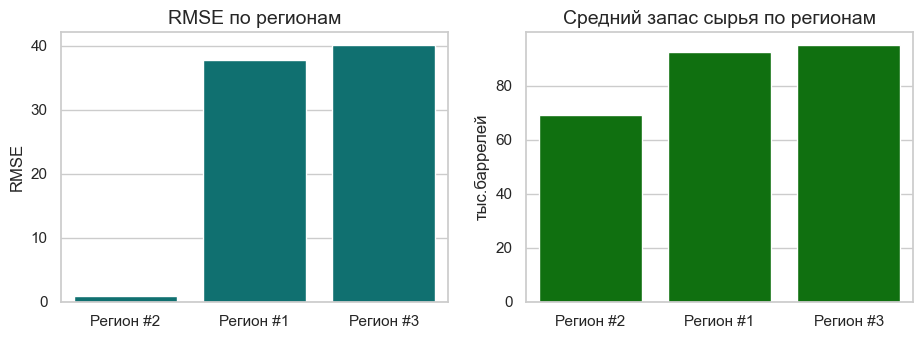

In [33]:
# Создание датафрейма с результатами модели
regions_results = pd.DataFrame({
    'mean_predict_product': [
        y_predict_mean_region_1, 
        y_predict_mean_region_2, 
        y_predict_mean_region_3
    ],
    'rmse': [
        rmse_region_1, 
        rmse_region_2, 
        rmse_region_3
    ]
}, 
index=['Регион #1', 'Регион #2', 'Регион #3']).sort_values(by='rmse')

# Вывод датафрейма с результатами модели
display(regions_results)

# Графики с результатами
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 3.5))
    
sns.barplot(regions_results['rmse'], ax=ax1, color='teal')
ax1.set_title('RMSE по регионам', fontsize=14)
ax1.set_ylabel('RMSE')

sns.barplot(regions_results['mean_predict_product'], ax=ax2, color='green')
ax2.set_title('Средний запас сырья по регионам', fontsize=14)
ax2.set_ylabel('тыс.баррелей');

**Выводы:**

* Самое низкое значение **RMSE** показал **Регион #2 - 0.888 тыс.баррелей**. Предсказания по другим регионам ошибаются намного больше - 37.815 тыс.баррелей в Регионе #1 и 40.129 тыс.баррелей в Регионе #3. 

Объяснить полученные результаты можно тем, что только в регионе #2 между целевым признаком `product` и одним из входным признаков (`f2`) прослеживалась сильная линейная взаимосвязь. В других регионах заметной линейной взаимосвязи не было, поэтому модели линейной регрессии не удалось найти закономерности в данных, что позволило бы получить более точные предсказания.
* В регионе #2 предсказан самый низкий средний запас сырья (`mean_predict_product`) - 68.962 тыс. баррелей. В регионах 1 и 3 предсказан в среднем на 25% больше запас сырья: 92.35 и 94.952 тыс.баррелей соответственно.

## Подготовка к расчету прибыли

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины и сравним результат со средним запасом в каждом регионе. 
- Количество скважин для разработки в регионе - 200.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- Доход с 1 тысячи баррелей сырья составляет 450 тыс. рублей

In [34]:
# Ключевые значения для расчета
BEST_POINTS = 200  # количество выбранных для разработки точек
RESEARCH_POINTS = 500  # количество исследуемых в регионе точек
BUDGET = 10_000_000_000  # бюджет на разработку, рубли
INCOME_PER_THOUSAND_BARRELS = 450_000  # доход с одной тысячи баррелей, рубли

Для расчета объёма сырья разделим бюджет на разработку скважин в регионе (`budget`) на количество выбранных для разработки точек (`best_points`). Полученное значение разделим на доход с одной тысячи баррелей.

In [35]:
# Расчёт объема сырья для безубыточной разработки новой скважины
break_even_volume = (BUDGET / BEST_POINTS) / INCOME_PER_THOUSAND_BARRELS

# Вывод результата
print(f'Объём сырья для безубыточной разработки новой скважины - {break_even_volume:.2f} тыс.баррелей')

Объём сырья для безубыточной разработки новой скважины - 111.11 тыс.баррелей


In [36]:
# Словарь со всеми датафреймами
all_regions = {
    'Регион #1': [geo_data_0_clean, y_region_1],
    'Регион #2': [geo_data_1_clean, y_region_2],
    'Регион #3': [geo_data_2_clean, y_region_3],
}

# Средний запас сырья в каждом регионе
for name, (df_clean, df_y) in all_regions.items():
    product_mean = df_clean['product'].mean()
    print(f'{name}: средний запас сырья - {product_mean:.2f} тыс.баррелей')

Регион #1: средний запас сырья - 92.50 тыс.баррелей
Регион #2: средний запас сырья - 68.81 тыс.баррелей
Регион #3: средний запас сырья - 94.79 тыс.баррелей


**Выводы:**

- Был рассчитан объём сырья, который необходим для безубыточной разработки новой скважины. Он составляет **111.11 тыс.баррелей.**
- Средний запас сырья в каждом из трех регионов **меньше объёма** для безубыточной разработки новой скважины: Регион #1 - 92.50 тыс. баррелей, Регион #2 - 68.81 тыс. баррелей, Регион #3 - 94.79 тыс. баррелей.

Однако это не означает, что разработка скважин в этих регионов определенно будет убыточной. Проанализируем данные с помощью техники Bootstrap, чтобы учесть вариативность данных и оценить вероятности различных исходов прибыли и убытков. После расчёта с использованием Bootstrap вполне может оказаться, что хотя средние запасы меньше порога безубыточности, разработка всё же может быть прибыльной в определенных регионах.

## Функция для расчета прибыли

Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели. Для этого выберем скважины с максимальными значениями предсказаний модели и просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям. Далее рассчитаем прибыль для полученного объёма сырья (выручка - затраты).

In [37]:
def profit_selected_wells(df, wells=BEST_POINTS):
    '''
    Расчет прибыли по выбранным скважинам.
    
    Parameters:
        df (pandas.DataFrame): DataFrame
        wells (int): количество выбранных для разработки точек. По умолчанию: значение 'BEST_POINTS'
        
    Returns:
        profit (float): значение прибыли по выбранным скважинам.
        
    '''

    # Сортировка предсказаний модели по убыванию
    predict_product_sorted = df.sort_values(by=['y_predict'], ascending=False)[:wells]
    
    # Сумма реального объема сырья
    valid_product_sum = predict_product_sorted['y_valid'].sum()

    # Расчет прибыли
    profit = (valid_product_sum * INCOME_PER_THOUSAND_BARRELS) - BUDGET
    
    return profit

In [38]:
# Прибыль для полученного объема сырья в каждом регионе
for name, (df_clean, df_y) in all_regions.items():
    print(f'{name}: прибыль для полученного объема сырья из 200 лучших скважин - '
          f'{profit_selected_wells(df_y):,.2f} рублей'.replace(',', ' '))

Регион #1: прибыль для полученного объема сырья из 200 лучших скважин - 3 252 359 903.11 рублей
Регион #2: прибыль для полученного объема сырья из 200 лучших скважин - 2 415 086 696.68 рублей
Регион #3: прибыль для полученного объема сырья из 200 лучших скважин - 2 385 314 465.93 рублей


**Выводы:**

- Была написала функция для расчета прибыли по выбранным скважинам и предсказаниям модели.
- Рассчитана прибыль для полученного объема сырья из 200 лучших скважин по каждому из регионов. Самая высокая прибыль из **Региона #1** - 3 252 359 903.11 рублей.

## Расчет прибыли и рисков

Рассчитаем прибыль и риски по каждому региону используя технику **Bootstrap** с 1000 выборок. Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков.

In [39]:
def bootstrap_profit(df, region_name, sample_size=RESEARCH_POINTS):
    '''
    Расчет прибыли и рисков, используя Bootstrap.
    
    Parameters:
        df (pandas.DataFrame): DataFrame
        region_name (str): название региона
        sample_size (int): размер выборки. По умолчанию: значение 'RESEARCH_POINTS'
        
    Returns:
        values_mln (pandas.Series): Series с 1000 значений прибыли, в миллионах рублей.
        
    '''

    state = np.random.RandomState(12345)
    
    values = []

    # Bootstrap
    for i in range(1000):
        df_subsample = df.sample(n=sample_size, replace=True, random_state=state)
        values.append(profit_selected_wells(df_subsample))

    values = pd.Series(values)

    # Расчет квантилей
    lower = values.quantile(0.025)
    higher = values.quantile(0.975)

    # Расчет прибыли и рисков
    loss_risk = (values < 0).mean() * 100
    values_mean = values.mean()
    values_mln = values / 1_000_000

    # Вывод результатов
    print(region_name)
    print(f'Средняя прибыль: {values_mean:,.2f} рублей'.replace(',', ' '))
    print(f'95%-й доверительный интервал: {lower:,.2f} - {higher:,.2f} рублей'.replace(',', ' '))
    print(f'Риск убытков: {loss_risk:.2f}%', end='\n\n')
    
    return values_mln

Регион №1
Средняя прибыль: 393 086 331.86 рублей
95%-й доверительный интервал: -146 392 843.70 - 898 526 291.75 рублей
Риск убытков: 6.60%

Регион №2
Средняя прибыль: 455 772 670.52 рублей
95%-й доверительный интервал: 55 766 165.53 - 851 765 420.27 рублей
Риск убытков: 1.50%

Регион №3
Средняя прибыль: 375 536 745.74 рублей
95%-й доверительный интервал: -136 944 412.12 - 857 034 891.82 рублей
Риск убытков: 7.70%



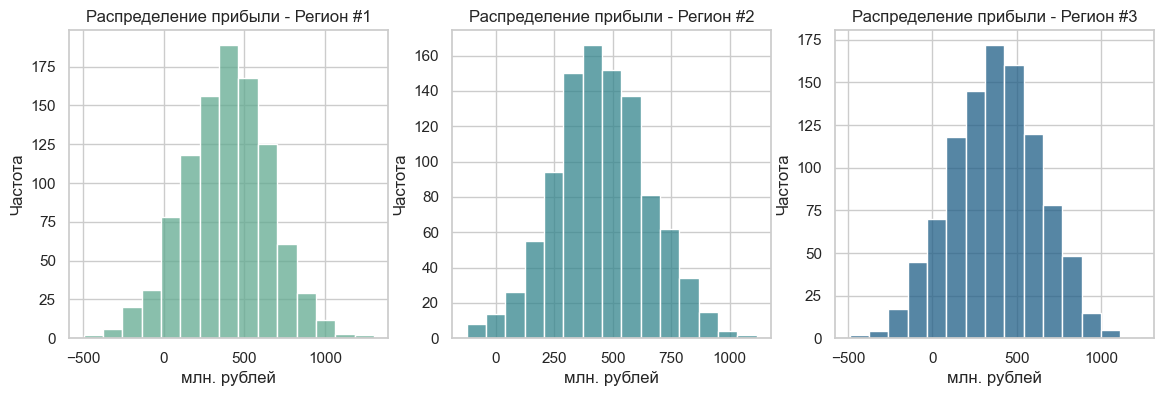

In [40]:
# Расчет прибыли и рисков по каждому региону
profit_region_1 = bootstrap_profit(y_region_1, 'Регион №1')
profit_region_2 = bootstrap_profit(y_region_2, 'Регион №2')
profit_region_3 = bootstrap_profit(y_region_3, 'Регион №3')

# Словарь с названиями датафреймов и самими датафреймами
profit_regions = {
    'Регион #1': profit_region_1,
    'Регион #2': profit_region_2,
    'Регион #3': profit_region_3
}

# Гистограммы распределения прибыли
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
colors = sns.color_palette('crest', len(profit_regions))

for i, (name, df) in enumerate(profit_regions.items()):
    sns.histplot(df, bins=15, ax=axes[i], color=colors[i]).set(
        title=f'Распределение прибыли - {name}', 
        xlabel='млн. рублей', 
        ylabel='Частота'
    )

**Выводы**:

Исходя из полученных результатов, для разработки скважин предлагаем **Регион #2**. В данном регионе самый низкий риск убытков - **1.5%** и самая высокая средняя прибыль - **455 772 670.52 рублей**. 

Оставшиеся регионы имеют высокий риск убытков: 6.6% в регионе #1 и 7.7% в регионе #3. Их 95%-й доверительный интервал включает в себя отрицательные значения, т.е. убыток. Следовательно разработка скважин в этих регионов является намного более рискованной с точки зрения убытков, чем в регионе #2.

## Общий вывод

В ходе проведенного исследования были выполнены следующие этапы и получены следующие основные результаты.

1) **Предобработка данных**

* Были обнаружены неявные дубликаты в 3-ёх датафреймах в столбце `id`. Они составили 0,006% от всего объема данных. Т.к. этот столбец не использовался при обучении модели и количество дубликатов малозначительное, оставили их без изменений.
* Были проверены пропущенные значения.
***
2) **Исследовательский анализ данных**

Рассмотрев основные данные геологоразведки трёх регионов, мы проанализировали распределение значений по каждому параметру, выявили средние значения, а также аномальные. В результате:
- Во всех трёх датафреймах наблюдаются признаки мультимодальности (особенно по признаку `f0`). Входные признаки в целом имеют различные распределения: от мультимодальных до нормальных.
- Целевой признак `product` везде имеет симметричное распределение и не содержит выбросов.
- Были обнаружены и удалены выбросы во входных признаках (`f0`, `f1`, и `f2`) в каждом из датафреймов. Они составили 1,06% от всего объема данных.
- Линейной зависимости между признаками `f0`, `f1` и целевым признаком `product` не выявили, однако есть указания на возможное разделение данных на кластеры.
- Признак `f2` во втором датафрейме имеет ярко выраженную линейную взаимосвязь с целевым показателем `product`. В первом и третьем же датафреймах демонстрирует слабую линейную зависимость.
***
3) **Корреляционный анализ данных**

Проанализировав корреляции между признаками, мы выявили следующие взаимосвязи:
* Наиболее высокий уровень корреляции целевой признак `product` имеет с признаком `f2`: коэффициент 0.976 в 'geo_data_1', 0.482 в 'geo_data_0' и 0.443 в 'geo_data_2'.
* С остальными признаками (`f0`, `f2`) целевой признак имеет слабую корреляцию: коэффициет не превышает 0.2.
* Отсутствие мультиколлинеарности среди входных признаков (все коэффициенты корреляции ниже 0.5).
***
4) **Обучение модели**

Для получения предсказаний использовалась модель линейной регрессии (LinearRegression). Наилучшие результаты показал **Регион 2**. Метрика RMSE для него составила 0.888 тыс.баррелей. Средний предсказанный объем сырья - 68.962 тыс. баррелей.
***
5) **Расчет прибыли и рисков**

- Был рассчитан объём сырья, необходимый для безубыточной разработки новой скважины. Он составил 111.11 тыс.баррелей.
- Используя технику Bootstrap с 1000 выборок были расчитаны средняя прибыль, 95%-й доверительный интервал и риск убытков для каждого региона.
- В результате наилучшие результаты показал **Регион #2**. В данном регионе самый низкий риск убытков - **1.5%** и самая высокая средняя прибыль - **455 772 670.52 рублей**. Именно данный регион мы предлагаем для разработки новых скважин.
***
6) **Итоги исследования**

- В ходе исследования была построена модель для предсказания объёмов запасов сырья в трёх регионах, что позволило оценить перспективность бурения новых скважин.
- На основании полученных данных и прогнозов были выбраны наиболее выгодные скважины в каждом регионе. Анализ методом Bootstrap позволил учесть неопределённость и риски, связанные с объёмом добычи и потенциальной прибылью. В результате был определён регион с наибольшей ожидаемой прибылью и приемлемым уровнем риска.

 Результаты исследования помогут компании принять обоснованное решение о вложении средств в бурение скважин в наиболее перспективном регионе. Это позволит минимизировать риски и максимизировать прибыль, улучшив стратегию развития компании в условиях неопределённости.